In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import ast
import numpy as np
import scipy.stats as stats
from math import ceil

In [2]:
filename = Path('./data/processed/20210818_evening_toilet_visits.csv')
df = pd.read_csv(filename, parse_dates=['start_time', 'end_time'])
visit_times = df['visit_time'][df['visit_time'].notnull()]

(array([0.0018797 , 0.00647452, 0.0075188 , 0.00438596, 0.00125313,
        0.00125313, 0.00020886, 0.00020886, 0.00041771, 0.00020886]),
 array([ 18.,  60., 102., 144., 186., 228., 270., 312., 354., 396., 438.]),
 <BarContainer object of 10 artists>)

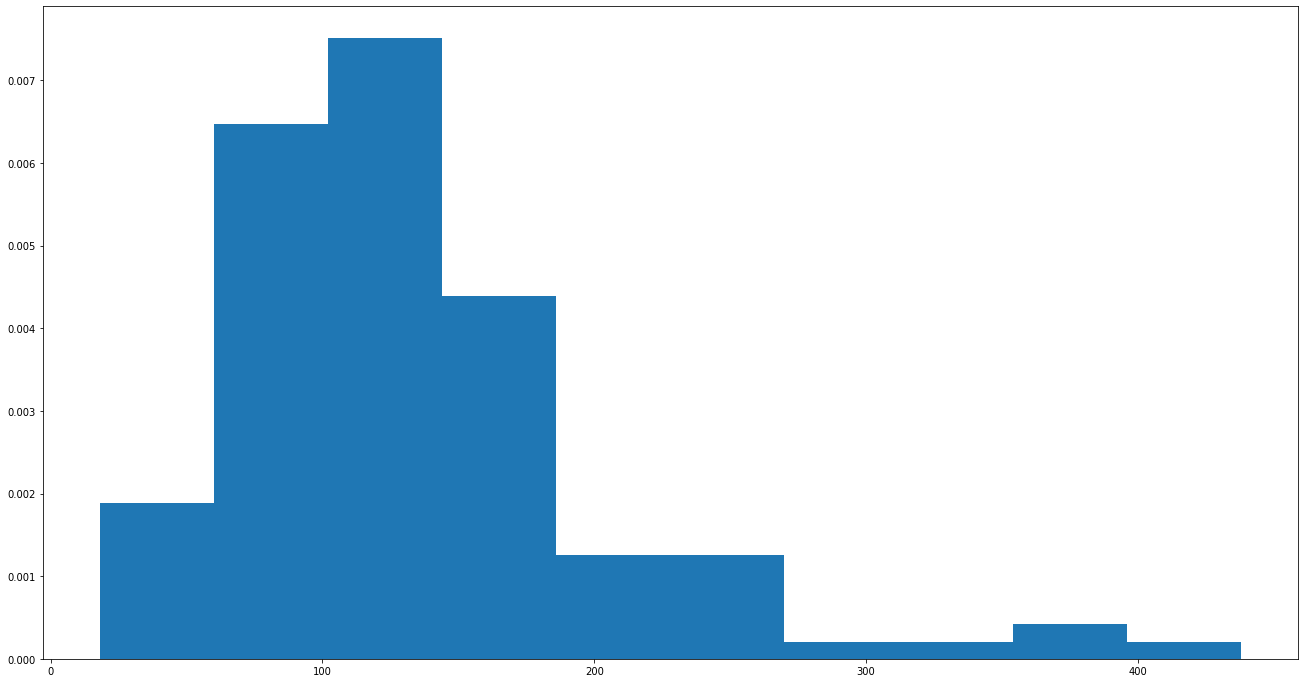

In [10]:
plt.rcParams['figure.figsize'] = [22.5,12]

plt.hist(visit_times, bins=10, density=True)

In [21]:
def process_line(line):
    line = line.strip()
    start_ind = 0
    parts = []
    for ii in range(3):
        comma_index = line.find(',', start_ind)
        value = line[start_ind:comma_index].strip()
        if ii == 1 or ii == 2:
            value = float(value)        
        start_ind = comma_index + 1
        parts.append(value)
        
    parts.append(ast.literal_eval(line[start_ind:].strip()))
    return parts

with open(Path('./data/stats/toilet_fits.txt'), 'r') as f:
    lines = [process_line(line) for line in f if '#' not in line]

min_value = min(visit_times)
max_value = max(visit_times)    

y, x = np.histogram(visit_times, bins=10, density=True)
bin_size = x[1] - x[0]
x = x[1:] - bin_size

y_l, x_l = np.histogram(visit_times, bins=20, density=True)
bin_size_l = x_l[1] - x_l[0]
x_l = x_l[1:] - bin_size_l


distrs = []
name_length_max = 0
for ii, distr_data in enumerate(lines):
    res = stats.cramervonmises(visit_times, distr_data[0], args=distr_data[3])
    dist = getattr(stats, distr_data[0])(*distr_data[3])
    y_dist = dist.pdf(x)    
    y_dist_l = dist.pdf(x_l)    
    try:
        r, p_pearson = stats.pearsonr(y, y_dist)   
        r_l, p_pearson_l = stats.pearsonr(y_l, y_dist_l)   
    except:
        r = np.nan
        p_pearson = np.nan
        r_l = np.nan
        p_pearson_l = np.nan
    distrs.append((distr_data[0], distr_data[2], res.pvalue, distr_data[3], r, p_pearson, r_l, p_pearson_l))
    
    if len(distr_data[0]) > name_length_max:
        name_length_max = len(distr_data[0])

distrs.sort(key=lambda el: el[2], reverse=True)        
    
print(f'{"name":>{name_length_max}s} - {"ks":>6s} -  {"cvm":>6s} - p - {"pear_r":>6s} -  {"pear_p":>6s} - {"peal_r":>6s} -  {"peal_p":>6s}')
for name, ks_p_value, cvm_p_value, params, r, p_pearson, r_l, p_pearson_l in distrs:    
    print(f'{name:>{name_length_max}s} - {ks_p_value:.4f} - {cvm_p_value:.4f} - {len(params)} - {r:.4f} - {p_pearson:.4f} - {r_l:.4f} - {p_pearson_l:.4f}')

              name -     ks -     cvm - p - pear_r -  pear_p - peal_r -  peal_p
         johnsonsu - 0.8872 - 0.9565 - 4 - 0.8764 - 0.0009 - 0.9310 - 0.0000
       levy_stable - 0.7579 - 0.8746 - 4 - 0.9010 - 0.0004 - 0.9372 - 0.0000
laplace_asymmetric - 0.7200 - 0.8345 - 3 - 0.8516 - 0.0018 - 0.8930 - 0.0000
              fisk - 0.6755 - 0.8234 - 3 - 0.9063 - 0.0003 - 0.9380 - 0.0000
              burr - 0.5674 - 0.7632 - 4 - 0.9129 - 0.0002 - 0.9371 - 0.0000
            mielke - 0.5509 - 0.7510 - 4 - 0.9139 - 0.0002 - 0.9369 - 0.0000
           laplace - 0.6855 - 0.6889 - 2 - 0.8372 - 0.0025 - 0.8900 - 0.0000
          dweibull - 0.6518 - 0.6885 - 3 - 0.8420 - 0.0022 - 0.8988 - 0.0000
           gennorm - 0.6667 - 0.6737 - 3 - 0.8457 - 0.0021 - 0.8892 - 0.0000
         exponnorm - 0.4968 - 0.6707 - 3 - 0.9078 - 0.0003 - 0.9355 - 0.0000
        skewcauchy - 0.8486 - 0.6685 - 3 - 0.8202 - 0.0037 - 0.8730 - 0.0000
               nct - 0.5192 - 0.6293 - 4 - 0.9159 - 0.0002 - 0.9363 - 0.0

10
450


C:\Users\martijnsparnaa\Anaconda3\envs\nomad_experiments\lib\site-packages\scipy\stats\_continuous_distns.py:3094: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  t1 = integrate.quad(llc, -np.inf, x)[0]
C:\Users\martijnsparnaa\Anaconda3\envs\nomad_experiments\lib\site-packages\scipy\stats\_continuous_distns.py:3099: RuntimeWarning: Infinite values encountered in scipy.special.kve. Values replaced by NaN to avoid incorrect results.
  warnings.warn(msg, RuntimeWarning)
C:\Users\martijnsparnaa\Anaconda3\envs\nomad_experiments\lib\site-packages\numpy\lib\function_base.py:2246: RuntimeWarning: invalid value encountered in _ppf_single (vectorized)
  outputs = ufunc(*inputs)
C:\Users\martijnsparnaa\Anaconda3\envs\nomad_experiments\lib\site-packages\scipy\stats\_continuous_distns.py:2804: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-inte

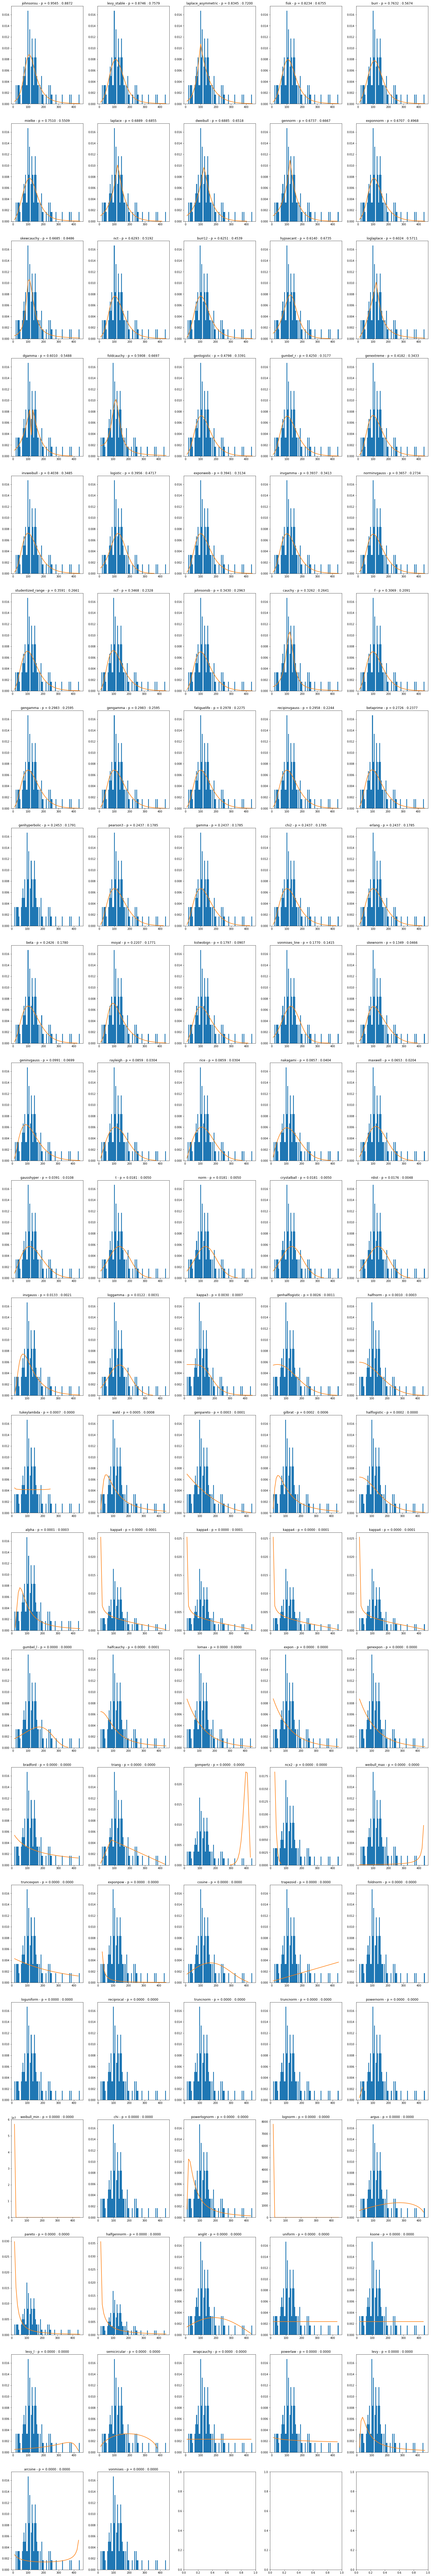

In [5]:
plt.rcParams['figure.figsize'] = [28.5,180]

col_count = 5
row_count = int(ceil(len(lines)/col_count))
_, axes = plt.subplots(row_count, col_count)

axes = axes.flatten()

import scipy.stats as stats

min_value = 10 #min(visit_times)
max_value = 450 #max(visit_times)
diff_value = max_value - min_value

print(min_value)
print(max_value)

#min_value -= diff_value*0.1
#max_value += diff_value*0.1

x_per_lim = 0.001

for ii, distr_data in enumerate(distrs):
    name, ks_p_value, cvm_p_value, params = distr_data
    hist = axes[ii].hist(visit_times, bins=40, density=True)
    dist = getattr(stats, name)(*params)
    x = np.arange(max(min_value, dist.ppf(x_per_lim)), min(max_value,dist.ppf(1-x_per_lim)), 10)
    axes[ii].plot(x, dist.pdf(x), linewidth=2)
    axes[ii].set_title(f'{name} - p = {cvm_p_value:.4f} : {ks_p_value:.4f}')